In [ ]:
import torch.nn as nn
from segmentation_models_pytorch import UnetPlusPlus, Segformer, DeepLabV3, DeepLabV3Plus, Unet
model = DeepLabV3Plus(encoder_name="resnet34", in_channels=1, classes=1)
model.segmentation_head[2] = nn.Sigmoid()
total_params = round(sum(p.numel() for p in model.parameters()) / 1e6,2)
print(f"Total Parameters: {total_params} M\n")

In [7]:
from monai.networks.nets import SwinUNETR
model = SwinUNETR(in_channels=1, out_channels=1, spatial_dims=2, feature_size=48)
total_params = round(sum(p.numel() for p in model.parameters()) / 1e6,2)
print(f"Total Parameters: {total_params} M\n")

Total Parameters: 25.14 M



In [1]:
from Scripts.model import UnetPlusPlus
model = UnetPlusPlus(1, 1, 64)
total_params = round(sum(p.numel() for p in model.parameters()) / 1e6,2)
print(f"Total Parameters: {total_params} M\n")

Total Parameters: 36.63 M



In [1]:
from Scripts.model import TEUnet, AAUnet, AttUnet, Unet, TEUnet2
model = TEUnet2(1,1,16)
total_params = round(sum(p.numel() for p in model.parameters()) / 1e6,2)
print(f"Total Parameters: {total_params} M\n")

/export/home/taowentao/Applications/Miniconda3/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Total Parameters: 6.83 M



In [2]:
import torch
images = torch.rand(size=(2,1,512,512))
out = model(images)

In [5]:
out = model.encoder(images)

In [5]:
import torch.nn as nn
import torch

nn.MaxPool2d(32)(torch.rand(size=(2,16,32,32))).shape

torch.Size([2, 16, 1, 1])

In [3]:
from Scripts.utils.metrics import metrics
m = metrics(csv_path="Results/metrics.csv", device="cuda:0")
m.load_dataset(database_name="BUSI")
m.load_model("Unet++", in_channels=1, out_channels=1, hidden_channels=64, seed=1)
m.evaluate()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

device = "cuda:1"
database_name = "BUSI"
model_name = "TEUnet2"
seed = 0
in_channels = 1
out_channels = 1
hidden_channels = 32
p = 0.0

def calc_dice_score(predicted, target, smooth=1e-5):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

def calc_iou_score(predicted, target):
    if torch.sum(predicted) == 0 and torch.sum(target) == 0:
        return 1.0
    intersection = torch.logical_and(predicted, target).sum()
    union = torch.logical_or(predicted, target).sum()
    iou = intersection / union if union != 0 else torch.tensor(0.0)
    return iou.item()

def calc_recall_score(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target * (~predicted))
    recall = true_positive / (true_positive + false_negative + 1e-5)
    return recall.item()


def calc_precision_score(predicted, target, smooth=1e-5):
    true_positive = torch.sum(predicted * target)
    false_positive = torch.sum(predicted * (1-target))
    precision = true_positive / (true_positive + false_positive + smooth)
    return precision.item()

def calc_specificity_score(predicted, target, smooth=1e-5):
    true_negtive = torch.sum((~predicted) * (1 - target))
    false_positive = torch.sum(predicted * (1 - target))
    specificity = true_negtive / (true_negtive + false_positive + smooth)
    return specificity.item()

from Scripts.model import TEUnet, AAUnet, AttUnet, Unet
from segmentation_models_pytorch import UnetPlusPlus, Segformer, DeepLabV3
from Scripts.utils.data import Database2Dataloader

if model_name == "Unet":
    from Scripts.model import Unet
    model = Unet(in_channels,out_channels,hidden_channels, p) 
elif model_name == "AttUnet":
    from Scripts.model import AttUnet
    model = AttUnet(in_channels,out_channels,hidden_channels, p)
elif model_name == "AAUnet":
    from Scripts.model import AAUnet
    model = AAUnet(in_channels,out_channels,hidden_channels//2, p)
elif model_name == "TEUnet":
    from Scripts.model import TEUnet
    model = TEUnet(in_channels,out_channels,hidden_channels//2, p)
elif model_name == "TEUnet2":
    from Scripts.model import TEUnet2_Encoder, TEUnet2_Decoder
    model_encoder = TEUnet2_Encoder(in_channels,out_channels,hidden_channels//2, p)
    model_encoder.load_state_dict(torch.load(f"./Checkpoints/TEUnet2Encoder_{database_name}_{seed}.pth", map_location=device))
    model_encoder.to(device).eval()
    model_decoder = TEUnet2_Decoder(in_channels,out_channels,hidden_channels//2, p)
    model_decoder.load_state_dict(torch.load(f"./Checkpoints/TEUnet2Decoder_{database_name}_{seed}.pth", map_location=device))
    model_decoder.to(device).eval()
elif model_name == "Unet++":
    from segmentation_models_pytorch import UnetPlusPlus
    model = UnetPlusPlus(encoder_name="resnet34", in_channels=in_channels, classes=out_channels)
elif model_name == "Segformer":
    from segmentation_models_pytorch import Segformer
    model = Segformer(encoder_name="resnet34", in_channels=in_channels, classes=out_channels)
elif model_name == "DeepLabV3+":
    from segmentation_models_pytorch import DeepLabV3Plus
    model = DeepLabV3Plus(encoder_name="resnet34", in_channels=in_channels, classes=out_channels)
elif model_name == "DeepLabV3":
    from segmentation_models_pytorch import DeepLabV3
    model = DeepLabV3(encoder_name="resnet34", in_channels=in_channels, classes=out_channels)
else:
    raise ValueError("Invalid model name")

if model_name not in ["TEUnet2"]:
    model.load_state_dict(torch.load(f"./Checkpoints/{model_name}_{database_name}_{seed}.pth", map_location=device))
    model.to(device).eval()

dataloader = Database2Dataloader(database_path=f"Database/{database_name}", seed=0)

iou_score = 0.0
dice_score = 0.0
recall_score = 0.0
precision_score = 0.0
specificity_score = 0.0
n = 0
maxpooler = nn.MaxPool2d(16,16)

for images, masks in tqdm(dataloader["test"]):
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        if model_name == "TEUnet":
            outputs = model(images)[1]
        elif model_name == "TEUnet2":
            outputs = model_decoder(model_encoder(images))
        elif model_name in ["Unet++", "Segformer", "DeepLabV3+", "DeepLabV3"]:
            outputs = model(images)
            outputs = F.sigmoid(outputs)
        else:
            outputs = model(images)
        
        dice_score += calc_dice_score(outputs>0.5, masks)
        iou_score += calc_iou_score(outputs>0.5, masks)
        recall_score += calc_recall_score(outputs>0.5, masks)
        precision_score += calc_precision_score(outputs>0.5, masks)
        specificity_score += calc_specificity_score(outputs>0.5, masks)
        n += 1
print(f"Test Dice Score: {dice_score/n:.4f}")
print(f"Test IoU Score: {iou_score/n:.4f}")
print(f"Test Recall Score: {recall_score/n:.4f}")
print(f"Test precision Score: {precision_score/n:.4f}")
print(f"Test specificity Score: {specificity_score/n:.4f}")

/export/home/taowentao/Applications/Miniconda3/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/export/home/taowentao/Applications/Miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 13/13 [00:11<00:00,  1.12it/s]

Test Dice Score: 0.7242
Test IoU Score: 0.5844
Test Recall Score: 0.7470
Test precision Score: 0.7476
Test specificity Score: 0.9813


In [3]:
import matplotlib.pyplot as plt
from Scripts.model import TEUnet2_Encoder, TEUnet2_Decoder
import torch

device = "cuda:0"
database_name = "BUSI"
in_channels = 1
out_channels = 1
hidden_channels = 64
p = 0
seed = 0

model_encoder = TEUnet2_Encoder(in_channels,out_channels,hidden_channels//2, p)
model_encoder.load_state_dict(torch.load(f"./Checkpoints/TEresUnet2Encoder_{database_name}_{seed}.pth", map_location=device))
model_encoder.to(device).eval()
model_decoder = TEUnet2_Decoder(in_channels,out_channels,hidden_channels//2, p, show_attention=True)
model_decoder.load_state_dict(torch.load(f"./Checkpoints/TEresUnet2Decoder_{database_name}_{seed}.pth", map_location=device))
model_decoder.to(device).eval()

from Scripts.utils.data import Database2Dataloader
dataloader = Database2Dataloader(database_path=f"Database/{database_name}", seed=0)

for images, masks in dataloader["test"]:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        features = model_encoder(images)
        outputs = model_decoder(features)
    break

/export/home/taowentao/Applications/Miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
outputs[2].shape

torch.Size([16, 1, 64, 64])

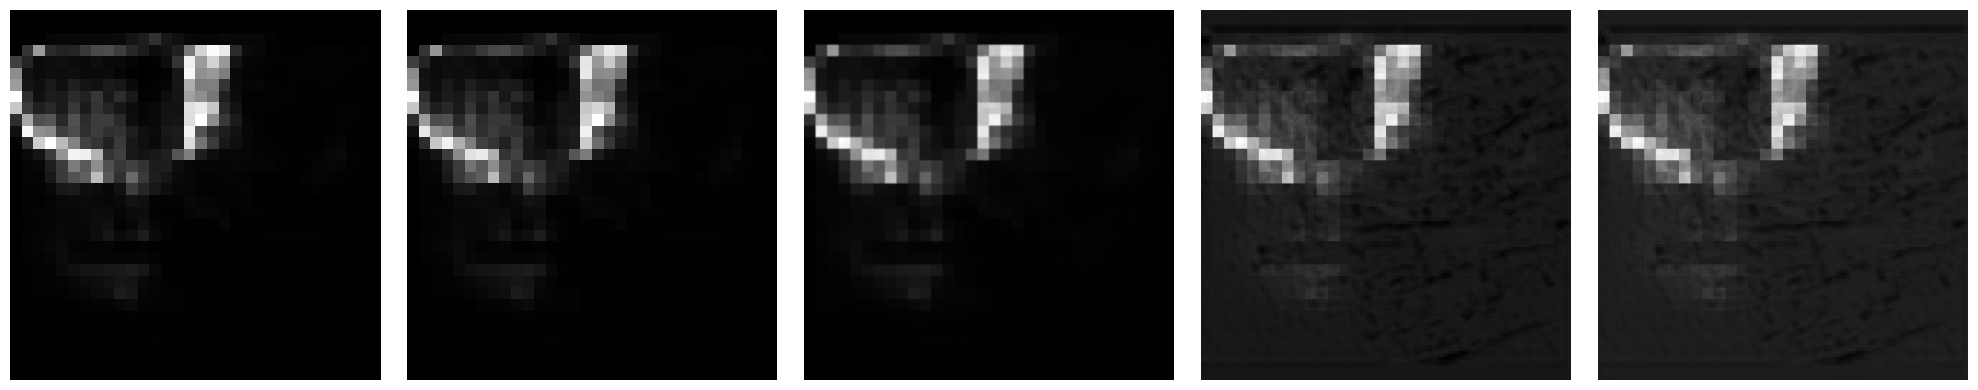

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(outputs[1][0,0,:,:].cpu(), cmap='gray')
ax1.axis('off')

ax2 = fig.add_subplot(1, 5, 2)
ax2.imshow(outputs[2][0,0,:,:].cpu(), cmap='gray')
ax2.axis('off')

ax3 = fig.add_subplot(1, 5, 3)
ax3.imshow(outputs[3][0,0,:,:].cpu(), cmap='gray')
ax3.axis('off')

ax4 = fig.add_subplot(1, 5, 4)
ax4.imshow(outputs[4][0,0,:,:].cpu(), cmap='gray')
ax4.axis('off')

ax4 = fig.add_subplot(1, 5, 5)
ax4.imshow(outputs[5][0,0,:,:].cpu(), cmap='gray')
ax4.axis('off')

plt.tight_layout()

plt.show()

In [28]:
import matplotlib.pyplot as plt
from Scripts.model import TEUnet2_Encoder, TEUnet2_Decoder
import torch

device = "cuda:0"
database_name = "BUSI"
model_name = "TEUnet"
in_channels = 1
out_channels = 1
hidden_channels = 64
p = 0
seed = 0

from Scripts.model import TEUnet
model = TEUnet(in_channels,out_channels,hidden_channels//2, p)
model.load_state_dict(torch.load(f"./Checkpoints/{model_name}_{database_name}_{seed}.pth", map_location=device))
model.to(device).eval()

from Scripts.utils.data import Database2Dataloader
dataloader = Database2Dataloader(database_path=f"Database/{database_name}", seed=0)

for images, masks in dataloader["test"]:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(images)
    break

(-0.5, 31.5, 31.5, -0.5)

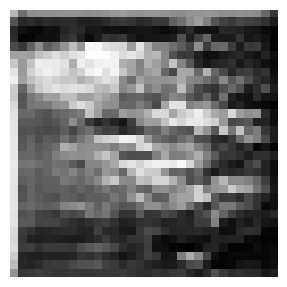

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(outputs[0][0,0,:,:].cpu(), cmap='gray')
ax1.axis('off')